In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rosbag
import myutil.myutil as util
from ceva import Ceva

import nlink_parser.msg._LinktrackNodeframe3 as ltf3


In [10]:
# bag = rosbag.Bag('/media/tmn/mySataSSD1/Experiments/gptr/linktrack/linktrack_01_line.bag')
bag = rosbag.Bag('/media/tmn/mySataSSD1/Experiments/gptr/linktrack/modified_linktrack_data_line1_2024-10-30-15-05-53.bag')

tag_topics = topics=['/nlink_linktrack_nodeframe3_tag0',
                     '/nlink_linktrack_nodeframe3_tag1',
                     '/nlink_linktrack_nodeframe3_tag2',
                     '/nlink_linktrack_nodeframe3_tag3']

p_W_a = np.loadtxt('/media/tmn/mySataSSD1/Experiments/gptr/linktrack/anccoordinates.txt', delimiter=',')
p_B_t = np.loadtxt('/media/tmn/mySataSSD1/Experiments/gptr/linktrack/tagcoordinates.txt', delimiter=',')

dis = []
for topic, msg, t in bag.read_messages(topics=tag_topics):
    tidx = tag_topics.index(topic)
    for node in msg.nodes:
        aidx = node.id
        dis.append((tidx, aidx, msg.header.stamp.to_sec(), node.dis))
dis = np.array(dis, dtype=[('tidx', int), ('aidx', int), ('t', float), ('d', float)])


Created spline of order 4, knot length 0.100000, from time 1.147613 to 46.447613; consisting of 456 knots


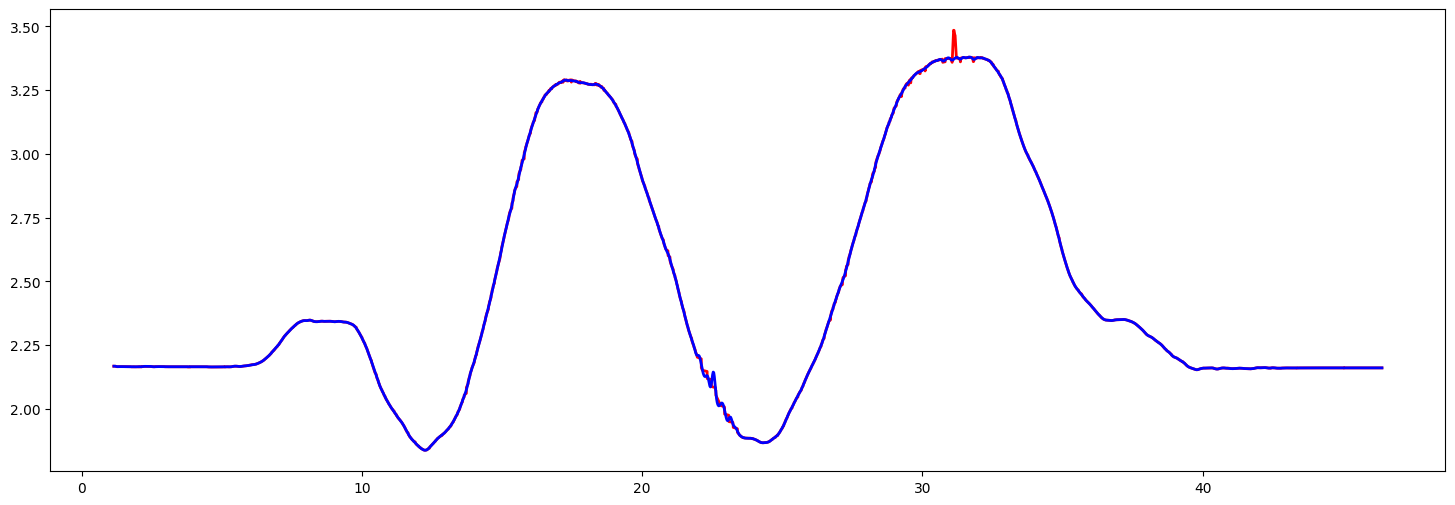

In [11]:

# Extract ground truth
gtr = []
for topic, msg, t in bag.read_messages(topics=['/vicon/uwbtags/uwbtags']):
    gtr.append((msg.header.stamp.to_sec(),
                msg.transform.translation.x,
                msg.transform.translation.y,
                msg.transform.translation.z,
                msg.transform.rotation.x,
                msg.transform.rotation.y,
                msg.transform.rotation.z,
                msg.transform.rotation.w))
gtr = np.array(gtr, dtype=[('t', float), ('x', float), ('y', float), ('z', float), ('qx', float), ('qy', float), ('qz', float), ('qw', float)])

gtr_ts  = np.array(gtr['t'].tolist())
gtr_pos = np.array(gtr[['x', 'y', 'z']].tolist())
gtr_rot = np.array(gtr[['qx', 'qy', 'qz', 'qw']].tolist())
gtr_nrm = []

# Check the rate of change
for idx, pos in enumerate(gtr_pos):
    gtr_nrm.append(np.linalg.norm(gtr_pos[idx, :]))

fig2 = plt.figure(figsize=(18, 6))
axnrm = fig2.subplots(1, 1)
axnrm.plot(gtr_ts, gtr_nrm, linewidth=2, color='r')

# Remove the outlier manually
keep_idx = []
for idx, nrm in enumerate(gtr_nrm):
    if 31.1 < gtr_ts[idx] < 31.17:
        continue
    else:
        keep_idx.append(idx)
gtr_ts  = gtr_ts [keep_idx]
gtr_pos = gtr_pos[keep_idx, :]
gtr_rot = gtr_rot[keep_idx, :]
gtr_nrm = np.array(gtr_nrm)[keep_idx]

tmin = float(min(gtr['t']))
tmax = float(max(gtr['t']))

# Fit the spline
wr = np.ones(shape=(len(gtr_ts), 1))
wp = np.ones(shape=(len(gtr_ts), 1))
spline = Ceva(4, 0.1, tmin, tmax)
spline.fitspline(gtr_ts, gtr_pos, gtr_rot, wr, wp, 10)

# Sample the spline
test = dis[(dis['t'] >= tmin) & (dis['t'] <= tmax)]['t'].tolist()
gtr_test = spline.getPose(test)

# Get the norm
gtr_nrm_est = [np.linalg.norm(p) for idx, p in enumerate(gtr_test[:, 1:4])]
axnrm.plot(gtr_test[:, 0], gtr_nrm_est, linewidth=2, color='b')


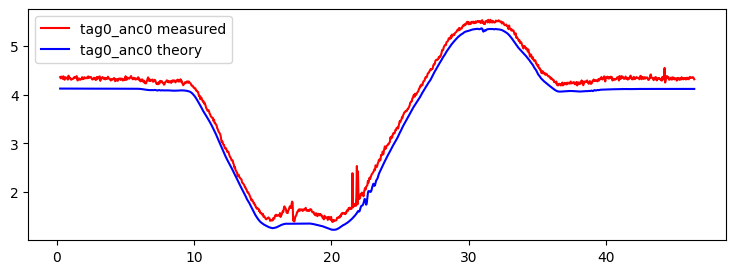

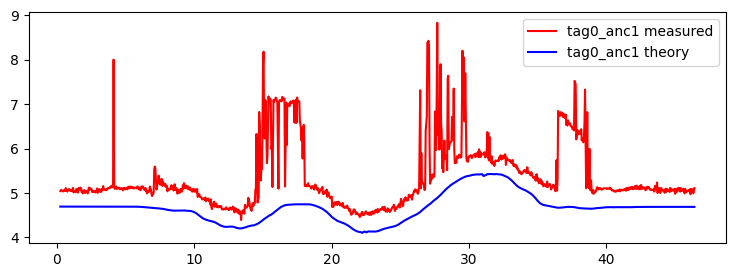

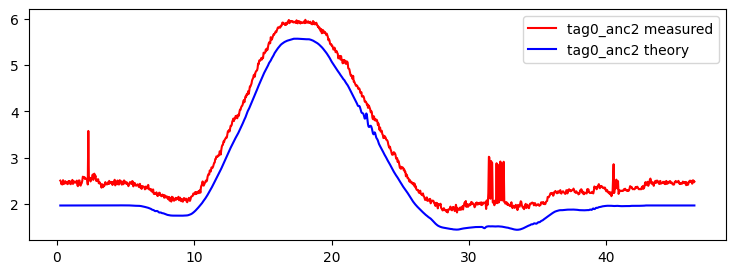

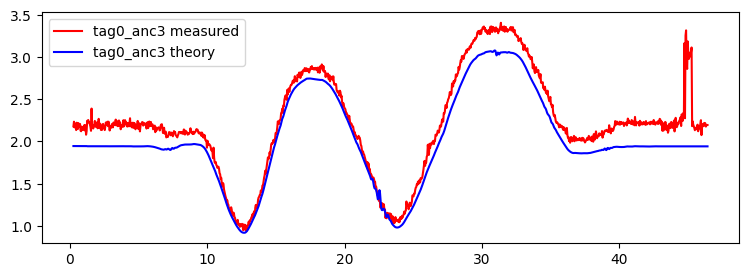

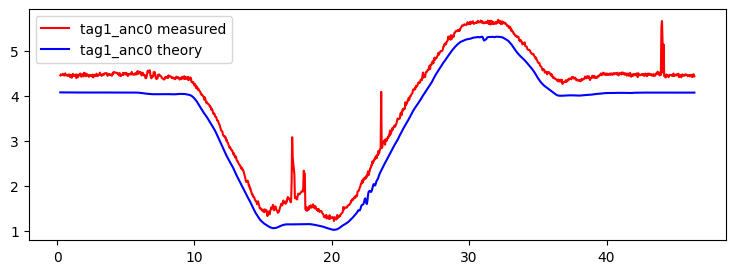

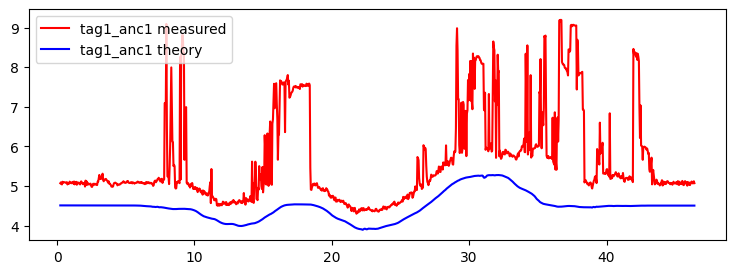

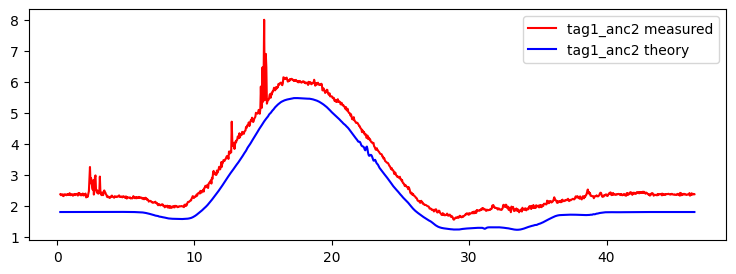

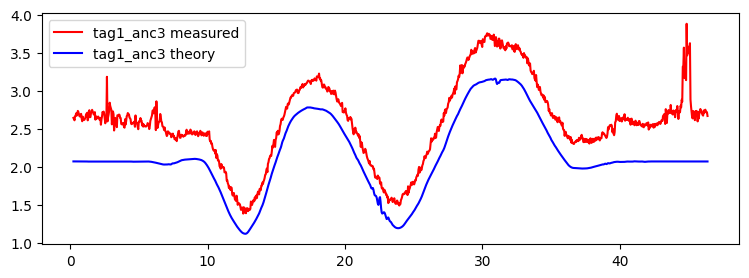

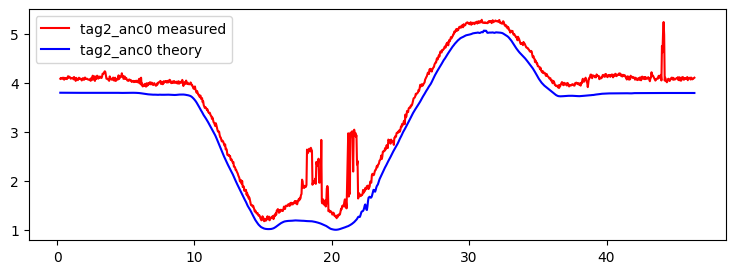

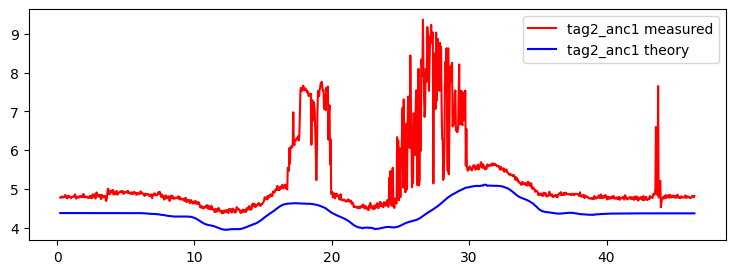

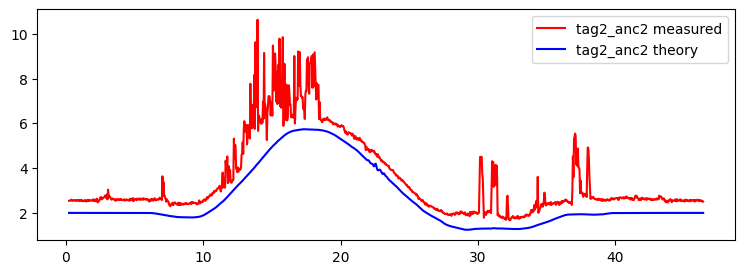

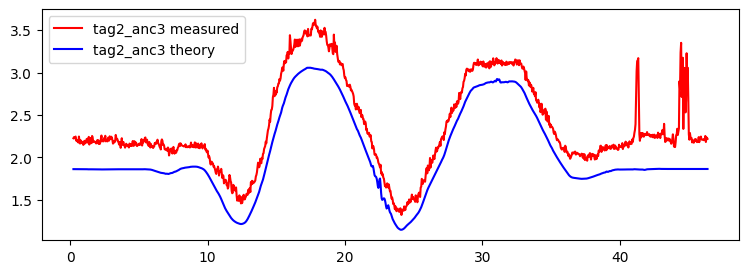

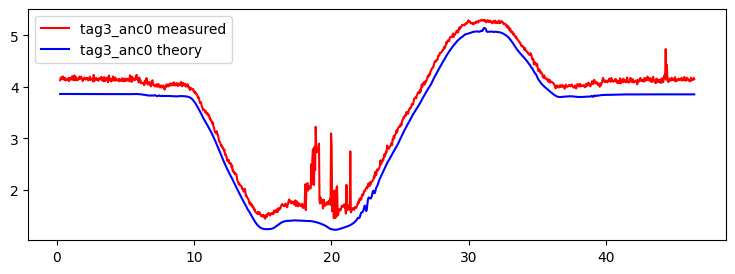

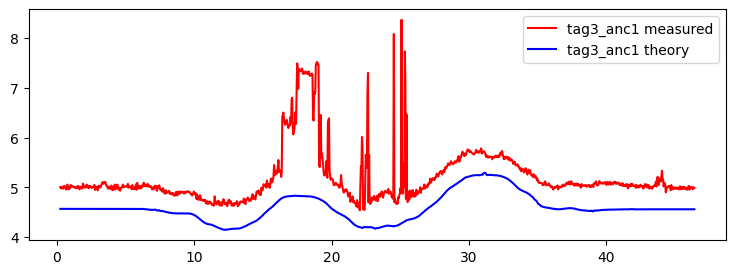

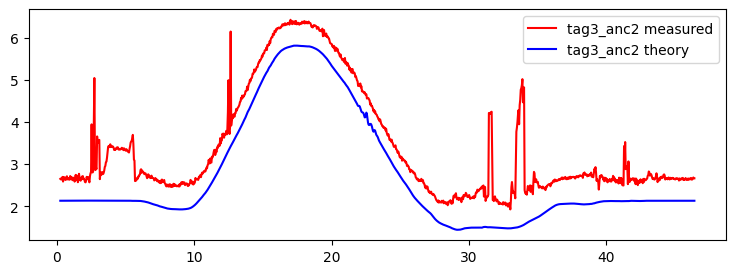

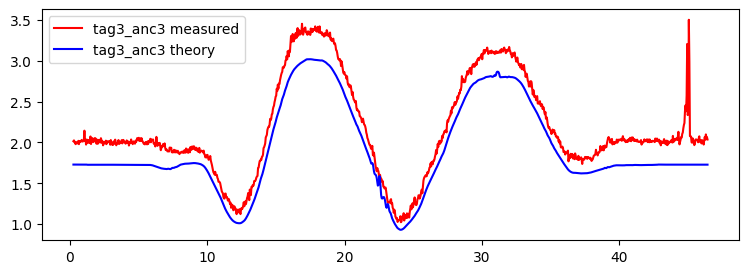

In [12]:
# Generate theorectical distance

dis_gtr = []
for idx, _ in enumerate(dis):
    
    # tag-anchor information
    ts = dis['t'][idx]
    aidx = dis['aidx'][idx]
    tidx = dis['tidx'][idx]

    p_B_tag = p_B_t[tidx, :].reshape((3, 1))
    p_W_anc = p_W_a[aidx, :].reshape((3, 1))
    
    # Sample the pose
    pose = spline.getPose(ts)
    R_W_B = util.quat2rotm(pose[:, [7, 4, 5, 6]][0]).reshape((3, 3))
    p_W_B = pose[:, [1, 2, 3]].reshape((3, 1))
    pat = p_W_B + R_W_B@p_B_tag - p_W_anc

    # Calculate the distance
    d = np.linalg.norm(pat)
    dis_gtr.append((tidx, aidx, ts, d))
    
dis_gtr = np.array(dis_gtr, dtype=[('tidx', int), ('aidx', int), ('t', float), ('d', float)])


# Plot the distances
tags = list(set(dis['tidx']))
ancs = list(set(dis['aidx']))
for tag in tags:
    for anc in ancs:
        fig = plt.figure(figsize=(9, 3))
        ax = fig.subplots(1, 1)
        dmeas = dis[(dis['aidx'] == anc) & (dis['tidx'] == tag)]
        dtrue = dis_gtr[(dis_gtr['aidx'] == anc) & (dis_gtr['tidx'] == tag)]
        ax.plot(dmeas['t'], dmeas['d'], label=f'tag{tag}_anc{anc} measured', color='r')
        ax.plot(dtrue['t'], dtrue['d'], label=f'tag{tag}_anc{anc} theory', color='b')
        ax.legend()

# Write the theorectical distance to the bag
outbag = rosbag.Bag('output.bag', 'w')
for topic, msg, t in bag.read_messages():
    if topic in tag_topics:
        for node in msg.nodes:
            ts = msg.header.stamp.to_sec()
            tidx = tag_topics.index(topic)
            aidx = node.id
            p_B_tag = p_B_t[tidx, :].reshape((3, 1))
            p_W_anc = p_W_a[aidx, :].reshape((3, 1))
            # Sample the pose
            pose = spline.getPose(ts)
            R_W_B = util.quat2rotm(pose[:, [7, 4, 5, 6]][0])
            p_W_B = pose[:, [1, 2, 3]].reshape((3, 1))
            # Calculate the distance
            d = np.linalg.norm(p_W_B + R_W_B@p_B_tag - p_W_anc)
            # Overwrite the distance
            node.dis = d
            # print(d)
    # Write the data to bag
    outbag.write(topic, msg, t)
outbag.close()